# Stream and view an OPERA CSLC-S1 using S3 Direct Access link

---    
This tutorial demonstrates how to stream and visualize the OPERA CSLC-S1 Data product from an s3 link.

### Data Used in the Example:   

- **10 meter (Northing) x 5 meter (Easting) North America OPERA Coregistered Single Look Complex from Sentinel-1 products**
    - This dataset contains Level-2 OPERA provisional coregistered single-look-complex (CSLC) data from Sentinel-1 (S1). <span style="color:red"> The data in this example is a geocoded CSLC-S1 data (burst_id: T042-088925-IW1) covering an area in Central California </span>. 
    
    - The OPERA project is generating geocoded burst-wise CSLC-S1 products over North America which includes USA and US Territories within 200 km from the US border, Canada, and all mainland countries from the southern US border down to and including Panama. Each pixel within a burst SLC is represented by a complex number and contains both the amplitude and phase information. The CSLC-S1 products are distributed over projected map coordinates using the Universal Transverse Mercator (UTM) projection with spacing in the X- and Y-directions of 5 m and 10 m, respectively. Each OPERA CSLC-S1 product is distributed as a HDF5 file following the CF-1.8 convention with separate groups containing the data raster layers, the low-resolution correction layers, and relevant product metadata.

    - For more information about the OPERA project and other products please visit our website at https://www.jpl.nasa.gov/go/opera .

Please refer to the [OPERA Product Specification Document](https://d2pn8kiwq2w21t.cloudfront.net/documents/ProductSpec_CSLC_URS314199.pdf) for details about the CSLC-S1 product.

*Prepared by M. Grace Bato*

---

In [1]:
import xarray as xr
import requests
# import boto3
import s3fs
import h5py
# import rasterio as rio
# import rioxarray
# from rasterio.session import AWSSession
import os
import matplotlib.pyplot as plt
import numpy as np
import shapely.wkt as wkt
from netrc import netrc
from subprocess import Popen
from platform import system
from getpass import getpass

In [2]:
# Generates authentication token
# Asks for your Earthdata username and password for first time, if netrc does not exists.

urs = 'urs.earthdata.nasa.gov'    # Earthdata URL endpoint for authentication
prompts = ['Enter NASA Earthdata Login Username: ',
           'Enter NASA Earthdata Login Password: ']

# Determine the OS (Windows machines usually use an '_netrc' file)
netrc_name = "_netrc" if system()=="Windows" else ".netrc"

# Determine if netrc file exists, and if so, if it includes NASA Earthdata Login Credentials
try:
    netrcDir = os.path.expanduser(f"~/{netrc_name}")
    netrc(netrcDir).authenticators(urs)[0]

# Below, create a netrc file and prompt user for NASA Earthdata Login Username and Password
except FileNotFoundError:
    homeDir = os.path.expanduser("~")
    Popen('touch {0}{2} | echo machine {1} >> {0}{2}'.format(homeDir + os.sep, urs, netrc_name), shell=True)
    Popen('echo login {} >> {}{}'.format(getpass(prompt=prompts[0]), homeDir + os.sep, netrc_name), shell=True)
    Popen('echo \'password {} \'>> {}{}'.format(getpass(prompt=prompts[1]), homeDir + os.sep, netrc_name), shell=True)
    # Set restrictive permissions
    Popen('chmod 0600 {0}{1}'.format(homeDir + os.sep, netrc_name), shell=True)

    # Determine OS and edit netrc file if it exists but is not set up for NASA Earthdata Login
except TypeError:
    homeDir = os.path.expanduser("~")
    Popen('echo machine {1} >> {0}{2}'.format(homeDir + os.sep, urs, netrc_name), shell=True)
    Popen('echo login {} >> {}{}'.format(getpass(prompt=prompts[0]), homeDir + os.sep, netrc_name), shell=True)
    Popen('echo \'password {} \'>> {}{}'.format(getpass(prompt=prompts[1]), homeDir + os.sep, netrc_name), shell=True)



In [3]:
def stream_cslc(s3f,pol):
    '''
    streaming OPERA CSLC in S3 bucket and retrieving CSLC and parameters from HDFs
    '''

    grid_path = f'data'
    metadata_path = f'metadata'
    burstmetadata_path = f'{metadata_path}/processing_information/input_burst_metadata'
    id_path = f'identification'

    with h5py.File(s3f,'r') as h5:
        cslc = h5[f'{grid_path}/{pol}'][:]
        azimuth_carrier_phase = h5[f'{grid_path}/azimuth_carrier_phase'][:]
        flattening_phase = h5[f'{grid_path}/flattening_phase'][:]
        xcoor = h5[f'{grid_path}/x_coordinates'][:]
        ycoor = h5[f'{grid_path}/y_coordinates'][:]
        dx = h5[f'{grid_path}/x_spacing'][()].astype(int)
        dy = h5[f'{grid_path}/y_spacing'][()].astype(int)
        epsg = h5[f'{grid_path}/projection'][()].astype(int)
        sensing_start = h5[f'{burstmetadata_path}/sensing_start'][()].astype(str)
        sensing_stop = h5[f'{burstmetadata_path}/sensing_stop'][()].astype(str)
        dims = h5[f'{burstmetadata_path}/shape'][:]
        bounding_polygon = h5[f'{id_path}/bounding_polygon'][()].astype(str) 
        orbit_direction = h5[f'{id_path}/orbit_pass_direction'][()].astype(str)
        center_lon, center_lat = h5[f'{burstmetadata_path}/center']
        wavelength = h5[f'{burstmetadata_path}/wavelength'][()].astype(str)
    
    return cslc, azimuth_carrier_phase, flattening_phase, xcoor, ycoor, dx, dy, epsg, sensing_start, sensing_stop, dims, bounding_polygon, orbit_direction, center_lon, center_lat, wavelength

In [4]:
# Generates the temporary s3 access
s3_cred_endpoint='https://cumulus.asf.alaska.edu/s3credentials'
 
def get_temp_creds():
    temp_creds_url=s3_cred_endpoint
    return requests.get(temp_creds_url).json()
 
temp_creds_req=get_temp_creds()
 
fs_s3 = s3fs.S3FileSystem(anon=False,
                          key=temp_creds_req['accessKeyId'],
                          secret=temp_creds_req['secretAccessKey'],
                          token=temp_creds_req['sessionToken'],
                          client_kwargs={'region_name':'us-west-2'})

In [5]:
# Open one example CSLC-S1
s3link='s3://asf-cumulus-prod-opera-products/OPERA_L2_CSLC-S1/OPERA_L2_CSLC-S1_T042-088925-IW1_20240113T140849Z_20240114T084800Z_S1A_VV_v1.0/OPERA_L2_CSLC-S1_T042-088925-IW1_20240113T140849Z_20240114T084800Z_S1A_VV_v1.0.h5'
with fs_s3.open(s3link, mode='rb') as s3obj:
        cslc,azimuth_carrier_phase,flattening_phase,xcoor,ycoor,dx,dy,epsg,sensing_start,sensing_stop,dims,bounding_polygon,orbit_direction,center_lon,center_lat,wavelength = stream_cslc(s3obj,'VV')

Text(0, 0.5, 'Latitude')

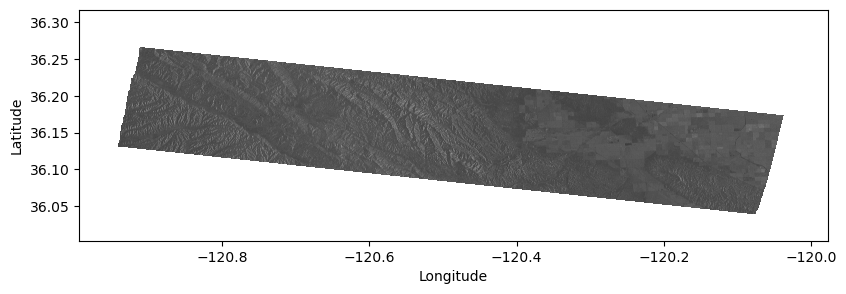

In [6]:
# Define bounding box
cslc_poly = wkt.loads(bounding_polygon)
bbox = [cslc_poly.bounds[0], cslc_poly.bounds[2], cslc_poly.bounds[1], cslc_poly.bounds[3]]

# Plot
scale_factor = 1.0; exp_factor= 0.2
fig, ax = plt.subplots(figsize=(12, 3))
cax=ax.imshow(scale_factor*(np.abs(cslc))**exp_factor, cmap='gray',interpolation=None, origin='upper', extent=bbox)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')